<a href="https://colab.research.google.com/github/asadian98/motornet-pro/blob/main/notebooks/motornet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install motornet

In [3]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import motornet as mn

A complex plant system: arm210

Now we will create a more complex plant, that uses a 2-DOF arm skeleton and a rigid-tendon Hill muscle.
We then build a muscle system containing 10 muscles inserted in various ways across each bone.

## 1. Building the plant
The coordinate system works according to the illustation below. The first coordinate of an insertion point is always in the direction of the bone that point is fixed on, and the second coordinate indicates the deviation perpendicular to that bone's direction.

In [4]:
arm210 = mn.plants.Plant(
  skeleton=mn.plants.skeletons.TwoDofArm(),
  muscle_type=mn.plants.muscles.CompliantTendonHillMuscle(),
  proprioceptive_delay=0.02,
  visual_delay=0.05,
  timestep=0.01,
  integration_method='rk4',
  excitation_noise_sd=0.001,
  pos_lower_bound=None,
  pos_upper_bound=None,
  vel_lower_bound=None,
  vel_upper_bound=None, 
  name='Arm210'
)

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.15, .03], [.094, 0.017]],
  name='pectoralis',
  max_isometric_force=838,
  tendon_length=.039,
  optimal_muscle_length=.134,
  normalized_slack_muscle_length=1.48)

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.034, .022], [.144, 0.01]],
  name='clavicular deltoid',
  max_isometric_force=680,
  tendon_length=.039,
  optimal_muscle_length=.104,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.14, 0.], [.05, -.00], [0.153, 0.]],
  name='deltoid',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.140,
  normalized_slack_muscle_length=1.52)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.1, 0.], [.05, -.03], [0.062, 0.004]],
  name='teres major',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.068,
  normalized_slack_muscle_length=1.65)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.23, 0.001], [0.231, 0.01]],
  name='brachioradialis',
  max_isometric_force=1422,
  tendon_length=.172,
  optimal_muscle_length=.092,
  normalized_slack_muscle_length=1.43)

arm210.add_muscle(
  path_fixation_body=[1., 1., 2.],
  path_coordinates=[[0.03, 0.], [0.138, -0.019], [-0.04, -0.017]],
  name='tricepslat',
  max_isometric_force=1549,
  tendon_length=.187,
  optimal_muscle_length=.093,
  normalized_slack_muscle_length=1.45)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[-0.052, 0.033], [0.044, 0.001]],
  name='biceps',
  max_isometric_force=414,
  tendon_length=.204,
  optimal_muscle_length=.137,
  normalized_slack_muscle_length=1.5)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[0.02, -0.028], [-0.04, -0.017]],
  name='tricepslong',
  max_isometric_force=603,
  tendon_length=0.217,
  optimal_muscle_length=0.127,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.306, -0.011], [0.003, -0.025]],
  name='anconeus',
  max_isometric_force=300,
  tendon_length=0.01,
  optimal_muscle_length=0.015,
  normalized_slack_muscle_length=1.72)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.277, 0.], [0.075, 0.02]],
  name='prot',
  max_isometric_force=700,
  tendon_length=0.02,
  optimal_muscle_length=0.058,
  normalized_slack_muscle_length=1.48)

arm210.print_muscle_wrappings()


MUSCLE NAME: pectoralis
-----------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.15000000596046448, 0.029999999329447746], [0.09399999678134918, 0.017000000923871994]]
max_isometric_force:  838
tendon_length:  0.039
optimal_muscle_length:  0.134
normalized_slack_muscle_length:  1.48


MUSCLE NAME: clavicular deltoid
-------------------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.03400000184774399, 0.02199999988079071], [0.14399999380111694, 0.009999999776482582]]
max_isometric_force:  680
tendon_length:  0.039
optimal_muscle_length:  0.104
normalized_slack_muscle_length:  1.4


MUSCLE NAME: deltoid
--------------------
n_fixation_points:  3
fixation body:  [0, 0, 1]
coordinates:  [[0.14000000059604645, 0.0], [0.05000000074505806, -0.0], [0.15299999713897705, 0.0]]
max_isometric_force:  1207
tendon_length:  0.066
optimal_muscle_length:  0.14
normalized_slack_muscle_length:  1.52


MUSCLE NAME: teres major
-------------------

# 2. Visualizing moment arms
Now we can visualize the moment of each muscle with respect to joint angles. Note that there are two surfaces per plot, one for the moment of the shoulder joint and one for the moment of the elbow joint. If a muscle does not span a joint, its moment arm will always be *0* regardless of the skeleton's joint configuration. In other words, if that muscle shortens or lengthens, it would alter the angle of the joint by *0*.


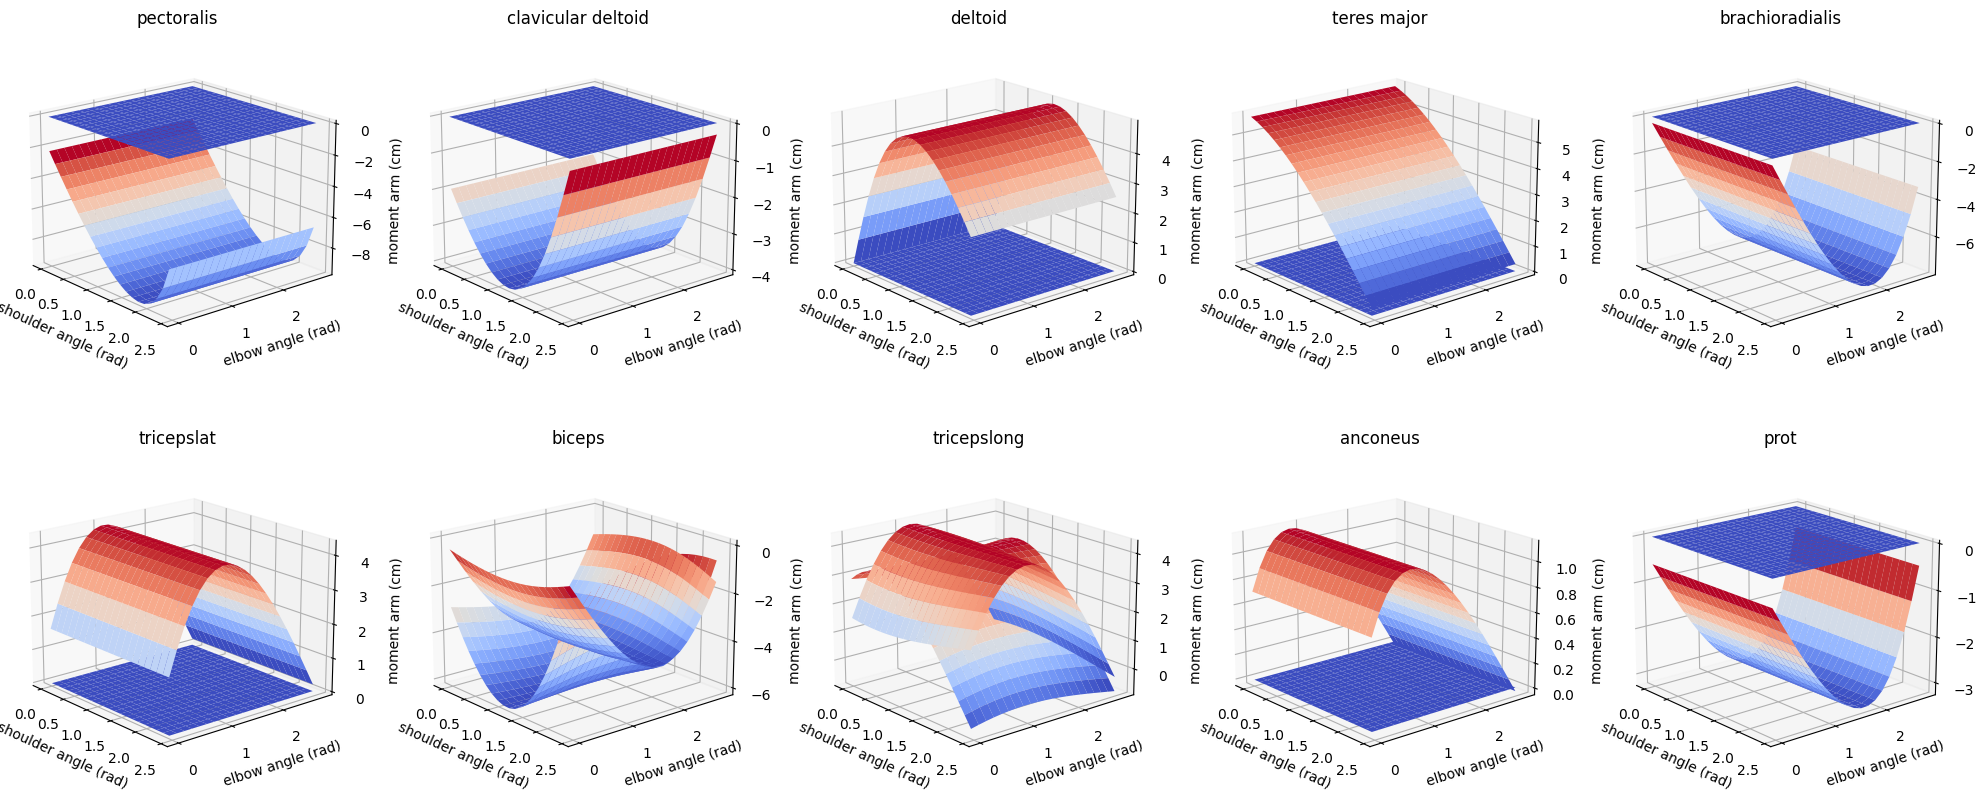

In [6]:
# create a grid of joint angles
n_states = 21  # grid resolution
sho, elb = np.meshgrid(
    np.linspace(arm210.pos_lower_bound[0], arm210.pos_upper_bound[0], n_states).astype('float32'),
    np.linspace(arm210.pos_lower_bound[1], arm210.pos_upper_bound[1], n_states).astype('float32'))

state0 = arm210.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1)], axis=1))
mstate = state0[-2].numpy().reshape((n_states, n_states, -1, arm210.n_muscles))
gstate = state0[-1].numpy().reshape((n_states, n_states, -1, arm210.n_muscles))


fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
# fig.set_tight_layout(True)
for m in range(arm210.n_muscles):
    ax = fig.add_subplot(2, 5, m+1, projection='3d')
    ax.plot_surface(sho, elb, gstate[:, :, 2, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.plot_surface(sho, elb, gstate[:, :, 3, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (cm)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(arm210.muscle_name[m])
plt.show()

fig.savefig('momentarms.svg', format='svg', dpi=1200)

## 3. Visualizing muscle lengths
We can also visualize each muscle's length as a function of joint angle.


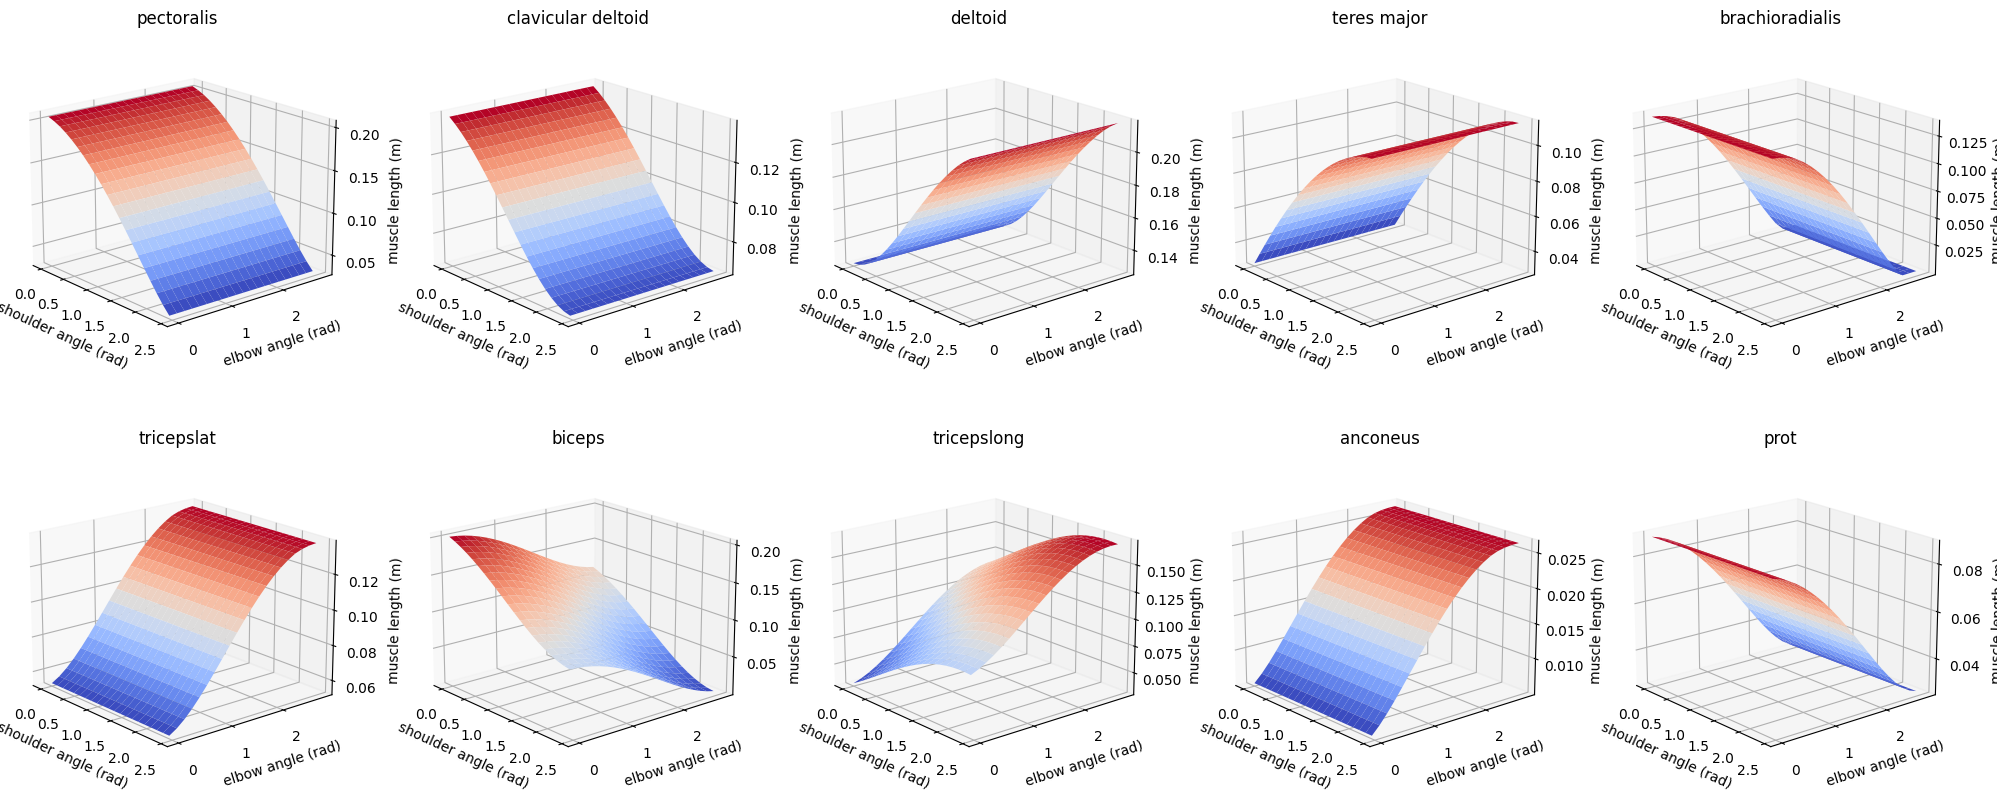

In [7]:
fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
# fig.set_tight_layout(True)
for m in range(arm210.n_muscles):
    ax = fig.add_subplot(2, 5, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 1, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('muscle length (m)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(arm210.muscle_name[m])
plt.show()

fig.savefig('musclelengths.svg', format='svg', dpi=1200)